In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Load data

In [12]:
pd.set_option("display.max_columns", None)
data_dir = Path.cwd().parent / "data"

In [15]:
# 1. CRSP–Compustat
crsp_compustat = pd.read_csv(
    data_dir / "crsp_compustat_raw.csv",
    parse_dates=["datadate", "MthCalDt"],
)

# Handle data
crsp_compustat["YYYYMM"] = pd.to_datetime(
    crsp_compustat["YYYYMM"], format="%Y%m"
).dt.to_period("M")
crsp_compustat["cal_year"] = crsp_compustat["MthCalDt"].dt.year
crsp_compustat["PERMNO"] = crsp_compustat["PERMNO"].astype("Int64")

# Keep only data on CRSP
crsp_compustat = crsp_compustat[crsp_compustat["PERMNO"].notna()]

# Keep only one entry per fiscal year, keeping the latest one
crsp_compustat = crsp_compustat.sort_values(
    ["PERMNO", "fyear", "datadate"]
).drop_duplicates(subset=["PERMNO", "fyear"], keep="last")

In [16]:
# 2. CRSP
crsp = pd.read_csv(
    data_dir / "crsp_raw.csv",
    parse_dates=["date"],
)

# Handle data
crsp["cal_year"] = crsp["date"].dt.year
crsp["PERMNO"] = crsp["PERMNO"].astype("Int64")
crsp["RET"] = pd.to_numeric(crsp["RET"], errors="coerce")

# Sort for all downstream rolling ops
crsp = crsp.sort_values(["PERMNO", "date"])


def geo_mean_return(x: pd.Series):
    # Drop NaNs, require at least one obs
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    return (1.0 + x).prod() ** (1.0 / len(x)) - 1.0


annual_ret = (
    crsp.groupby(["PERMNO", "cal_year"])
    .agg(
        ret_arith=("RET", "mean"),
        ret_geo=("RET", geo_mean_return),
        n_months=("RET", "count"),  # useful sanity check
        SHRCD=("SHRCD", "first"),
        EXCHCD=("EXCHCD", "first"),
    )
    .reset_index()
)


def add_36m_vol(group: pd.DataFrame) -> pd.DataFrame:
    # Sort, put date as index
    g = group.sort_values("date").set_index("date")

    # Enforce a regular monthly index (month-end). Missing months become NaN rows.
    g = g.asfreq("ME")

    # Rolling over the last 36 monthly observations (36 calendar months)
    g["vol_36m"] = g["RET"].rolling(window=36, min_periods=12).std()

    return g.reset_index()


crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)
crsp_with_vol["cal_year"] = crsp_with_vol["date"].dt.year

# Pick the last month in each calendar year for each PERMNO
year_end_rows = (
    crsp_with_vol.sort_values(["PERMNO", "date"])
    .groupby(["PERMNO", "cal_year"])
    .tail(1)  # last monthly obs in that year
)

annual_vol = year_end_rows[["PERMNO", "cal_year", "vol_36m"]]

annual_crsp = annual_ret.merge(annual_vol, on=["PERMNO", "cal_year"], how="left")


C:\Users\chris\AppData\Local\Temp\ipykernel_24808\26881786.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)


In [55]:
# 3. Merge
df = crsp_compustat.merge(
    annual_crsp,
    on=["PERMNO", "cal_year"],
    how="left",
)

df = df.sort_values(["PERMNO", "MthCalDt"])

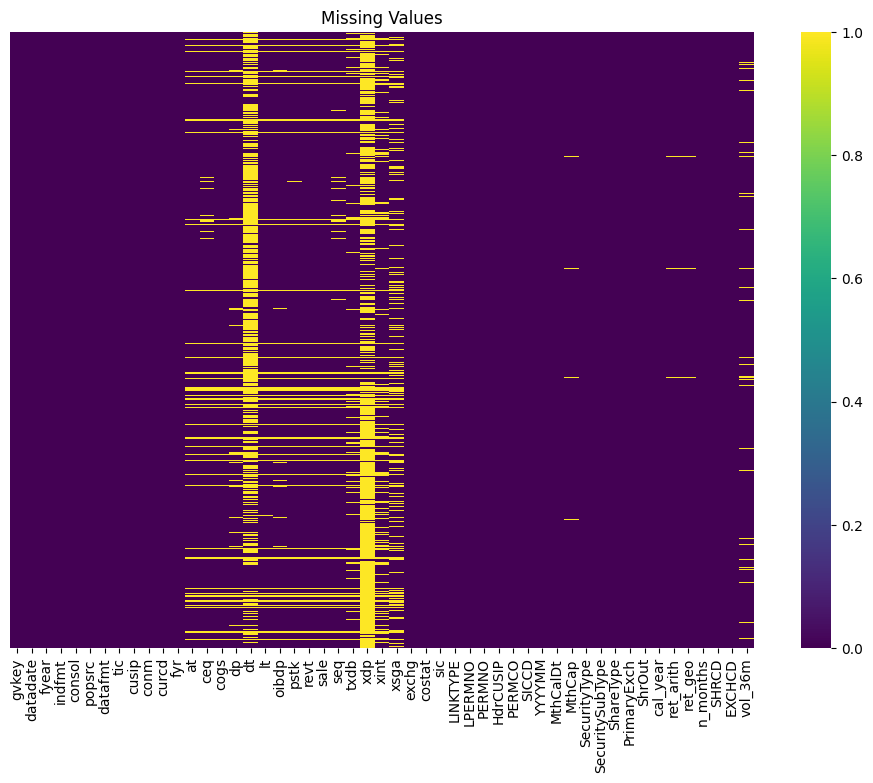

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

### Stock universe filtering

In [56]:
# Filters:
df = df[df["SHRCD"].isin([10, 11])]  # common stock only
df = df[df["EXCHCD"].isin([1, 2, 3])]  # NYSE/AMEX/NASDAQ
df = df[(df["SICCD"] < 6000) | (df["SICCD"] > 6799)]  # no finance/insurance/REIT

# Now use a heuristic for finding big companies to only include, used to avoid survivorship-bias
# Assume we can use the MthCap per company, and that the timings align for comparing market capitalization

# NYSE only firms
nyse = df[df["EXCHCD"] == 1]

# Compute NYSE median each year
size_breakpoints = (
    nyse.groupby(nyse["MthCalDt"].dt.year)["MthCap"].median().rename("NYSE_Median")
)

df = df.merge(size_breakpoints, left_on=df["MthCalDt"].dt.year, right_index=True)

# Assign BIG / SMALL
df["SIZE"] = np.where(df["MthCap"] >= df["NYSE_Median"], "BIG", "SMALL")

# The paper keeps ONLY big stocks
df_big = df[df["SIZE"] == "BIG"].copy()

In [57]:
# Define target columns
cols_to_keep = [
    # identifiers
    "PERMNO",
    "gvkey",
    "tic",
    "cusip",
    "conm",
    # "YYYYMM",
    "MthCalDt",
    "SHRCD",
    "EXCHCD",
    # market data
    "ShrOut",
    "MthCap",
    "ret_arith",
    "ret_geo",
    "n_months",
    "vol_36m",
    # core balance sheet variables
    "at",
    "ceq",
    "seq",
    "pstk",
    "lt",
    # profitability
    "oibdp",
    "revt",
    "sale",
    # expenses
    "cogs",
    "dp",
    "xint",
    "xsga",
    # tax
    "txdb",
    "dt",
    # industry
    "sic",
    "SICCD",
]

df_big = df_big[cols_to_keep].copy()

# Rename for clarity
df_big = df_big.rename(
    columns={
        "MthCap": "market_cap",
        "MthCalDt": "date",
        "ShrOut": "n_shares",
        "at": "total_assets",
        "ceq": "common_equity",
        "seq": "shareholders_equity",
        "pstk": "preferred_stock",
        "lt": "total_liabilities",
        "oibdp": "oper_income",
        "revt": "revenue",
        "sale": "sales",
        "cogs": "cogs_expense",
        "dp": "depr_amort",
        "xint": "interest_expense",
        "xsga": "sga_expense",
        "txdb": "tax_deferred",
        "dt": "total_taxes",
    }
)


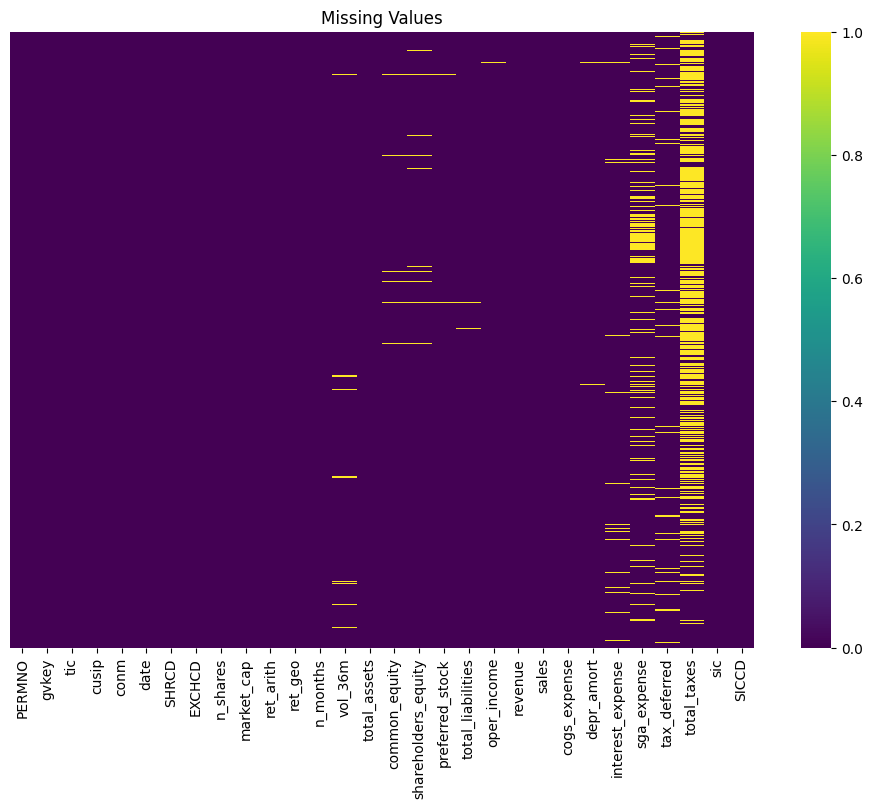

In [58]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_big.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

In [59]:
df_big.to_csv("data_clean.csv")

In [39]:
df_big.head(50)

,PERMNO,gvkey,tic,cusip,conm,YYYYMM,MthCalDt,SHRCD,EXCHCD,ShrOut,MthCap,ret_arith,ret_geo,n_months,vol_36m,total_assets,common_equity,shareholders_equity,preferred_stock,total_liabilities,oper_income,revenue,sales,cogs_expense,depr_amort,interest_expense,sga_expense,tax_deferred,total_taxes,sic,SICCD
72,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1962-10,1962-10-31,10.0,1.0,1453.0,9.880400e+04,0.018009,0.014739,12,NaN,251.200,NaN,NaN,NaN,128.316,25.590,214.300,214.300,168.570,9.990,4.070,20.140,11.562,NaN,3743,3743.0
73,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1963-10,1963-10-31,10.0,1.0,2906.0,1.460265e+05,0.045897,0.042782,12,0.073097,255.400,128.494,128.494,0.0,126.860,30.200,228.600,228.600,180.320,11.290,4.150,18.080,13.747,NaN,3743,3743.0
74,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1964-10,1964-10-30,10.0,1.0,2948.0,2.564760e+05,0.024327,0.023460,12,0.064884,272.600,138.533,138.533,0.0,134.032,41.470,277.700,277.700,217.130,11.660,4.520,19.100,16.826,NaN,3743,3743.0
75,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1965-10,1965-10-29,10.0,1.0,5936.0,2.656360e+05,0.019789,0.018039,12,0.056150,293.700,153.246,153.246,0.0,140.461,57.170,304.100,304.100,227.720,12.560,4.390,19.210,19.315,NaN,3743,3743.0
76,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1966-10,1966-10-31,10.0,1.0,5920.0,2.331000e+05,-0.012097,-0.013576,12,0.059158,328.700,166.152,166.152,0.0,162.567,60.780,323.200,323.200,243.420,12.930,3.670,19.000,23.176,NaN,3743,3743.0
77,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1967-10,1967-10-31,10.0,1.0,5748.0,2.723115e+05,0.019695,0.017418,12,0.071000,361.700,175.675,175.675,0.0,186.033,71.220,342.600,342.600,245.260,13.950,4.890,26.120,26.883,NaN,3743,3743.0
78,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1968-10,1968-10-31,10.0,1.0,5643.0,3.103650e+05,0.037436,0.032014,12,0.077695,376.600,180.013,180.013,0.0,196.569,58.700,276.500,276.500,189.440,15.540,6.310,28.360,30.652,NaN,3743,3743.0
79,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1969-10,1969-10-31,10.0,1.0,5641.0,2.827551e+05,-0.012458,-0.016394,12,0.090563,420.645,187.961,187.961,0.0,232.066,62.627,270.225,270.225,185.572,17.519,8.117,22.026,31.125,NaN,3743,3743.0
80,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1970-06,1970-06-30,10.0,1.0,5641.0,2.171785e+05,0.001063,-0.001259,12,0.084459,434.941,191.858,191.858,0.0,242.382,70.570,320.200,320.200,222.510,18.980,9.260,27.120,36.149,NaN,3743,3743.0
81,10006,1010,4165A,00099V004,ACF INDUSTRIES INC,1971-06,1971-06-30,10.0,1.0,5614.0,3.101735e+05,0.017539,0.014026,12,0.086964,470.518,195.671,195.671,0.0,274.051,66.179,333.718,333.718,238.889,20.992,11.354,28.650,44.941,NaN,3743,3743.0
